### 0. 기본환경 세팅

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


gpu 환경 체크

In [2]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-54b694f9-d986-6044-2dcc-c2338be81f91)


In [ ]:
# 데이터셋과 transformers 설치
!pip install datasets>=2.6.1
!pip install git+https://github.com/huggingface/transformers

# 오디오 처리를 위한 librosa 설치
!pip install librosa

# 성능 측정을 위한 evaluate와 jiwer 설치
!pip install evaluate>=0.30
!pip install jiwer

# 인터랙티브 인터페이스를 위한 gradio 설치
!pip install gradio

# Transformers와 PyTorch를 함께 사용하기 위한 accelerate 설치
!pip install transformers[torch]
!pip install accelerate>=0.20.1

In [4]:
from dataclasses import dataclass
from typing import Any, Dict, List, Union
import torch

### 1. 함수 정의

In [5]:
@dataclass
class DataCollatorSpeechSeq2SeqWithPadding:
    """
    Use Data Collator to perform Speech Seq2Seq with padding
    """
    processor: Any

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lengths and need different padding methods
        # first treat the audio inputs by simply returning torch tensors
        input_features = [{"input_features": feature["input_features"]} for feature in features]
        batch = self.processor.feature_extractor.pad(input_features, return_tensors="pt")

        # get the tokenized label sequences
        label_features = [{"input_ids": feature["labels"]} for feature in features]
        # pad the labels to max length
        labels_batch = self.processor.tokenizer.pad(label_features, return_tensors="pt")

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        # if bos token is appended in previous tokenization step,
        # cut bos token here as it's append later anyways
        if (labels[:, 0] == self.processor.tokenizer.bos_token_id).all().cpu().item():
            labels = labels[:, 1:]

        batch["labels"] = labels

        return batch

In [ ]:
from datasets import load_metric

wer_metric = load_metric("wer")

In [7]:
def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(labels_ids, skip_special_tokens=True)

    wer = wer_metric.compute(predictions=pred_str, references=label_str)

    return {"wer": wer}


### 2. 음성 처리에 필요한 기능

In [8]:
from transformers import WhisperFeatureExtractor, WhisperTokenizer, WhisperProcessor

# Load Feature extractor: WhisperFeatureExtractor
feature_extractor = WhisperFeatureExtractor.from_pretrained("openai/whisper-tiny")

# Load Tokenizer: WhisperTokenizer
tokenizer = WhisperTokenizer.from_pretrained("openai/whisper-tiny", language="en", task="transcribe")

# Load Processor: WhisperProcessor
processor = WhisperProcessor.from_pretrained("openai/whisper-tiny", language="en", task="transcribe")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/185k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/283k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/836k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.48M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/494k [00:00<?, ?B/s]

normalizer.json:   0%|          | 0.00/52.7k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.19k [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


### 3. 데이터셋 불러오기

In [9]:
from datasets import load_from_disk

# Load the combined 'train' dataset
loaded_train_dataset = load_from_disk('/content/drive/MyDrive/ComprehensiveDesign_modeling/data/map_dataset_tiny/train')

# Load the combined 'test' dataset
loaded_test_dataset = load_from_disk('/content/drive/MyDrive/ComprehensiveDesign_modeling/data/map_dataset_tiny/test')


Loading dataset from disk:   0%|          | 0/19 [00:00<?, ?it/s]

In [10]:
print(loaded_train_dataset)
print(loaded_test_dataset)

Dataset({
    features: ['input_features', 'labels'],
    num_rows: 9523
})
Dataset({
    features: ['input_features', 'labels'],
    num_rows: 502
})


### 4. 학습 및 평가

In [11]:
# STEP 5.1. Initialize the Data collator
data_collator = DataCollatorSpeechSeq2SeqWithPadding(processor=processor)

# STEP 5.1. Define evaluation metric
import evaluate
metric = evaluate.load("wer")

# STEP 5.3. Load a pre-trained Checkpoint
from transformers import WhisperForConditionalGeneration
model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-tiny")

model.config.forced_decoder_ids = None
model.config.suppress_tokens = []


# STEP 5.4. Define the training configuration
"""
Check for Seq2SeqTrainingArguments here:
https://huggingface.co/docs/transformers/main_classes/trainer#transformers.Seq2SeqTrainingArguments
"""
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer

training_args = Seq2SeqTrainingArguments(
    output_dir="./whisper_tiny_0528",  # 저장된 모델 및 결과물의 디렉토리 경로
    per_device_train_batch_size=32,  # 한 번에 처리되는 훈련 배치 크기
    gradient_accumulation_steps=2,  # 배치 크기 감소시 그래디언트 누적을 통한 학습 안정화
    learning_rate=1e-5,  # 학습률
    warmup_steps=80,  # 초기 학습률 조정을 위한 웜업 스텝 수 / 일반적으로는 10% ~ 20%의 전체 학습 스텝 수에 해당하는 값을 시도
    max_steps=480,  # 전체 훈련 스텝 수
    gradient_checkpointing=True,  # 그래디언트 체크포인팅을 통한 메모리 절약
    fp16=True,  # FP16 형식으로 훈련 수행 (반정밀도 부동소수점)( cpu 가동시 안씀)
    evaluation_strategy="steps",  # 검증 수행 전략 설정 ['no', 'steps', 'epoch']
    per_device_eval_batch_size=16,  # 한 번에 처리되는 검증 배치 크기
    predict_with_generate=True,  # 생성된 토큰을 통해 예측 수행
    generation_max_length=225,  # 생성된 토큰의 최대 길이 / 대화형 : 225 , 강연 : 400 or 500
    eval_steps=80,  # 검증 수행 스텝 수
    logging_steps=80,  # 로그 기록 스텝 수
    load_best_model_at_end=False,  # 훈련 종료 시 최적 모델 로드 여부
    metric_for_best_model="wer",  # 최적 모델 선정을 위한 평가 지표
    greater_is_better=False,  # 평가 지표 값이 높을수록 좋은지 여부
    save_steps=80  # 변경된 save_steps 값
)

# Initialize a trainer.
"""
Forward the training arguments to the Hugging Face trainer along with our model,
dataset, data collator and compute_metrics function.
"""
# 지정된 인자 및 구성요소로 트레이너를 초기화합니다
trainer = Seq2SeqTrainer(
    args=training_args,                   # 이전에 정의한 훈련 인자
    model=model,                          # 훈련할 ASR 모델
    train_dataset=loaded_train_dataset,# 훈련 데이터셋
    eval_dataset=loaded_test_dataset,  # 평가 데이터셋
    data_collator=data_collator,           # 데이터 전처리를 위한 데이터 콜레이터
    compute_metrics=compute_metrics,          # wer 메트릭을 계산하는 함수
    tokenizer=processor.feature_extractor, # 입력 오디오 데이터를 처리하기 위한 토크나이저
)

# Save processor object before starting training
processor.save_pretrained(training_args.output_dir)

# STEP 5.5. Training
"""
Training will take appr. 5-10 hours depending on your GPU.
"""
print('Training 시작')
trainer.train()   # <-- training 시작
print('Training 완료')

#"Step": 모델의 훈련 과정에서 진행되는 각 스텝을 나타내는 숫자입니다.
#스텝은 주로 배치(batch) 단위로 모델이 업데이트되는 지점을 의미합니다.

# Training Loss는 모델이 훈련 데이터에 대해 얼마나 정확하게 예측하는지를 나타내는 지표
# Training Loss가 감소하면 모델이 훈련 데이터에 대해 더 잘 학습하고 있는 것
# 모델이 데이터에 더 잘 적합되고 있다는 것을 의미

# Validation Loss는 모델이 이전에 본 적이 없는 검증 데이터에 대한 예측 정확도
# 훈련 과정 중에 일정 주기마다 검증 데이터를 사용하여 Validation Loss를 계산
# 이 값이 감소하면 모델이 일반화되고 있는 것을 의미
# 모델이 훈련 데이터뿐만 아니라 새로운 데이터에도 잘 예측할 수 있도록 학습되고 있다는 것

config.json:   0%|          | 0.00/1.98k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/151M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/3.75k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1483: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
max_steps is given, it will override any value given in num_train_epochs


Training 시작


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
`use_cache = True` is incompatible with gradient checkpointing. Setting `use_cache = False`...


Step,Training Loss,Validation Loss,Wer
80,3.509800,1.542209,0.569914


Due to a bug fix in https://github.com/huggingface/transformers/pull/28687 transcription using a multilingual Whisper will default to language detection followed by transcription instead of translation to English.This might be a breaking change for your use case. If you want to instead always translate your audio to English, make sure to pass `language='en'`.
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 448, 'suppress_tokens': [], 'begin_suppress_tokens': [220, 50257]}
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not p

Step,Training Loss,Validation Loss,Wer
80,3.509800,1.542209,0.569914
160,1.529500,1.417196,0.523725
240,1.374600,1.382577,0.536093
320,1.311500,1.367970,0.549218
400,1.223700,1.362651,0.589601
480,1.211600,1.360488,0.549470


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 448, 'suppress_tokens': [], 'begin_suppress_tokens': [220, 50257]}
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.c

Training 완료


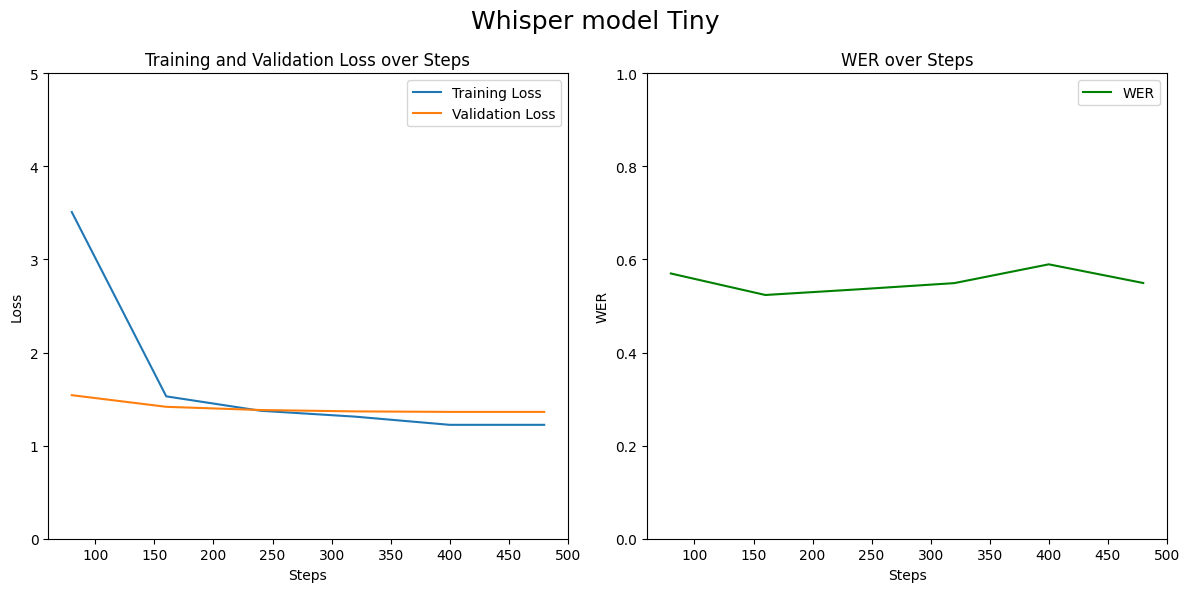

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# 데이터 준비
steps = [80, 160, 240, 320, 400, 480]
train_losses = [3.509800, 1.529500, 1.374600, 1.311500, 1.223700, 1.223700]
val_losses = [1.542209, 1.417196, 1.382577, 1.367970, 1.362651, 1.362651]
wer_list = [0.569914, 0.523725, 0.536093, 0.549218, 0.589601, 0.549470]

# 데이터프레임 생성
df = pd.DataFrame({
    'Steps': steps,
    'Training Loss': train_losses,
    'Validation Loss': val_losses,
    'WER': wer_list
})

# 그래프 생성 (1,2 배치)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# 첫 번째 그래프 (Training Loss, Validation Loss)
df.plot(x='Steps', y=['Training Loss', 'Validation Loss'], kind='line', ax=ax1)
ax1.set_title('Training and Validation Loss over Steps')
ax1.set_xlabel('Steps')
ax1.set_ylabel('Loss')
ax1.set_ylim([0, 5])  # y축의 범위를 0에서 5로 설정
ax1.legend()

# 두 번째 그래프 (WER)
df.plot(x='Steps', y='WER', kind='line', color='green', ax=ax2)
ax2.set_title('WER over Steps')
ax2.set_xlabel('Steps')
ax2.set_ylabel('WER')
ax2.set_ylim([0, 1])  # y축의 범위를 0에서 5로 설정

# 전체 그래프에 대한 제목 추가
fig.suptitle('Whisper model Tiny', fontsize=18)

plt.tight_layout()
plt.show()


학습된 모델 평가

In [12]:
trainer.evaluate(language='en')

You have passed language=en, but also have set `forced_decoder_ids` to [[1, None], [2, 50359]] which creates a conflict. `forced_decoder_ids` will be ignored in favor of language=en.


{'eval_loss': 1.360487699508667,
 'eval_wer': 0.5234729934376577,
 'eval_runtime': 112.505,
 'eval_samples_per_second': 4.462,
 'eval_steps_per_second': 0.284,
 'epoch': 3.221476510067114}

### 5. 모델 저장

In [ ]:
trainer.save_model("/content/drive/MyDrive/ComprehensiveDesign_modeling/model/whisper_tiny_0528")

In [14]:
from transformers import AutoTokenizer

# Load the trained tokenizer
tokenizer = AutoTokenizer.from_pretrained("/content/whisper_tiny_0528")

# Specify the directory where you want to save the tokenizer
save_directory = "/content/drive/MyDrive/ComprehensiveDesign_modeling/model/whisper_tiny_0528"

# Save the tokenizer to the specified directory
tokenizer.save_pretrained(save_directory)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


('/content/drive/MyDrive/ComprehensiveDesign_modeling/model/whisper_tiny_0528/tokenizer_config.json',
 '/content/drive/MyDrive/ComprehensiveDesign_modeling/model/whisper_tiny_0528/special_tokens_map.json',
 '/content/drive/MyDrive/ComprehensiveDesign_modeling/model/whisper_tiny_0528/vocab.json',
 '/content/drive/MyDrive/ComprehensiveDesign_modeling/model/whisper_tiny_0528/merges.txt',
 '/content/drive/MyDrive/ComprehensiveDesign_modeling/model/whisper_tiny_0528/normalizer.json',
 '/content/drive/MyDrive/ComprehensiveDesign_modeling/model/whisper_tiny_0528/added_tokens.json',
 '/content/drive/MyDrive/ComprehensiveDesign_modeling/model/whisper_tiny_0528/tokenizer.json')

### 6. 모델 실행

In [15]:
from transformers import pipeline
import soundfile as sf  # soundfile 라이브러리 사용

# ASR 파이프라인 초기화
model_name_or_path = "/content/drive/MyDrive/ComprehensiveDesign_modeling/model/whisper_tiny_0528"
asr = pipeline(model=model_name_or_path, task="automatic-speech-recognition")

# 음성 파일 경로 리스트
audio_file_paths = [
    "/content/drive/MyDrive/ComprehensiveDesign_modeling/data/audio/100038_audio.wav",
    "/content/drive/MyDrive/ComprehensiveDesign_modeling/data/audio/100114_audio.wav",
    "/content/drive/MyDrive/ComprehensiveDesign_modeling/data/audio/100128_audio.wav",
    # 추가 음성 파일 경로
]

# ASR 함수 정의
def transcribe_audio(audio_path):
    transcription = asr(audio_path)
    return transcription['text']  # Use 'text' key to get the transcribed text

# 각 음성 파일에 대한 처리 및 출력
for audio_file_path in audio_file_paths:
    transcription_text = transcribe_audio(audio_file_path)
    print(f"음성 파일: {audio_file_path}")
    print("텍스트 출력:", transcription_text)
    print()

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.10/dist-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


음성 파일: /content/drive/MyDrive/ComprehensiveDesign_modeling/data/audio/100038_audio.wav
텍스트 출력: and i'd like to have it



/usr/local/lib/python3.10/dist-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


음성 파일: /content/drive/MyDrive/ComprehensiveDesign_modeling/data/audio/100114_audio.wav
텍스트 출력: any one in



/usr/local/lib/python3.10/dist-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


음성 파일: /content/drive/MyDrive/ComprehensiveDesign_modeling/data/audio/100128_audio.wav
텍스트 출력: let me formulate a response to that festive

